In [1]:
#| default_exp fasthlight

In [2]:
#| export
from fasthtml.common import *
from fasthtml.jupyter import JupyUvi, HTMX
from monsterui.all import *
import os
from dotenv import load_dotenv

In [3]:
#| export
import fitz  # PyMuPDF
from dataclasses import dataclass
from datetime import datetime
from collections import Counter
from typing import Union
from urllib.parse import urlparse

In [4]:
#| export
from argon2 import PasswordHasher
from argon2.exceptions import VerifyMismatchError 

In [5]:
#| export
load_dotenv() 

True

In [6]:
os.getenv('SECRET_KEY')

'my-super-secret-key-change-in-production'

# Config

In [7]:
#| export 
@dataclass
class AppConfig:
    """Application configuration"""
    # Highlight Validation
    max_highlight_length: int = 10_000
    max_url_length: int = 2_000
    max_title_length: int = 500
    default_highlight_color: str = '#ffff00'
    
    # File Upload
    max_pdf_size_mb: int = 50
    allowed_file_types: list = None
    
    # UI Timing
    upload_success_delay: int = 2
    login_success_delay: int = 1
    toast_duration: int = 5
    
    # Authentication
    min_password_length: int = 8
    session_max_age: int = 31536000
    
    # Database
    db_path: Path = None
    
    # Pagination
    highlights_per_page: int = 50
    sources_per_page: int = 20

    def __post_init__(self):
        if self.allowed_file_types is None: self.allowed_file_types = ['.pdf']

        if self.db_path is None: self.db_path = Path('/data') if Path('/data').exists() else Path('.')

        self.db_path.mkdir(exist_ok=True)

    @property
    def max_pdf_size_bytes(self):
        """Convert MB to bytes for easier validation"""
        return self.max_pdf_size_mb * 1024 * 1024
    
    @property
    def db_file_path(self):
        """Full path to database file"""
        return self.db_path / 'highlights.db'

# Create global config instance
config = AppConfig()

# Highlights

In [8]:
#| export
@dataclass
class HighlightData:
    text: str
    page: int
    color: str  # We'll store as string for simplicity
    created: datetime  # ISO format datetime string

In [9]:
path = Path('pdf_test.pdf')
highlights = L()
with fitz.open(path) as doc:
    for page_num, page in enumerate(doc, 1):
        for annot in page.annots():
            if annot.type[0] == 8:  # 8 is highlight annotation
                # Use the annotation's rect directly
                rect = annot.rect
                text = page.get_text("text", clip=rect).strip()
                
                highlights.append(HighlightData(
                    text=text,
                    page=page_num,
                    color=annot.colors.get('stroke', [1, 1, 0]),
                    created=datetime.now()
                ))

This approach grabs annotation rectangle (baiscally from the beginning of the line even if the highlight was from the middle of the line)

In [10]:
highlights[0]

HighlightData(text='соглашением,  преимущественную силу имеют настоящие условия, за  исключением случаев, когда \nсоглашением прямо  предусмотрено внесение изменений в отдельные положения  настоящих условий. При', page=1, color=[1.0, 1.0, 0.0], created=datetime.datetime(2025, 12, 1, 23, 23, 58, 135073))

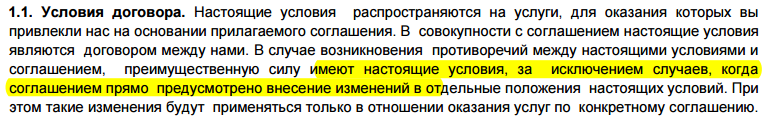

In [11]:
#| export
def rgb_to_hex(rgb_tuple):
    """Convert RGB tuple (0-1 range) to hex color string"""
    r, g, b = [int(c * 255) for c in rgb_tuple]
    return f"#{r:02x}{g:02x}{b:02x}"

## Extract Highlights

In [12]:
#| export
def extract_highlights(pdf: Union[str, Path, bytes]):
    """Extract highlights from PDF file path or bytes content
    Returns tuple of (highlights_list, error_message)
    - If successful: (highlights, None)
    - If error: ([], error_message)
    """
    highlights = L()
    doc = None
    
    try:
        
        doc = fitz.open(pdf) if isinstance(pdf, Path) else fitz.open(stream=pdf, filetype='pdf')

        # check if pdf is encrypted | protected by password
        if doc.is_encrypted: return highlights, "PDF is protected. Please remove the password first."
            
        for page_num in range(len(doc)):
            page = doc[page_num]
            annots = page.annots()
            if not annots: continue
            
            for annot in annots:
                # annotations (type 8), underline (9), strikeout (10), squiggly (11)
                if annot.type[0] not in [8, 9, 10, 11]: continue
    
                quads = annot.vertices
                highlighted_text = ""
                for i in range(0, len(quads), 4):
                    rect = fitz.Quad(quads[i:i+4]).rect
                    highlighted_text += page.get_text("text", clip=rect).strip()

                if not highlighted_text.strip(): continue
                
                hex_color = rgb_to_hex(annot.colors.get("stroke", (1.0, 1.0, 0.0)))
                
                highlights.append(HighlightData(
                    text=highlighted_text,
                    page=page_num + 1,
                    color=hex_color,
                    created=datetime.now()
                ))
        return highlights, None

    except Exception as e:
        error_msg = str(e)

        if "damaged" in error_msg.lower() or "corrupt" in error_msg.lower(): return highlights, "PDF file appears to be corrupted or damaged."
        elif "password" in error_msg.lower() or "encrypted" in error_msg.lower(): return highlights, "PDF is password protected."
        elif "format" in error_msg.lower(): return highlights, "Invalid PDF format."
        else:  return highlights, f"Error reading PDF: {error_msg}"
        
    finally:
        if doc: doc.close()

In [13]:
extract_highlights(path)[0]

(#5) [HighlightData(text='меют настоящие условия, за  исключением случаев, когдасоглашением прямо  предусмотрено внесение изменений в от', page=1, color='#ffff00', created=datetime.datetime(2025, 12, 1, 23, 23, 58, 169036)),HighlightData(text='ам или членам группы лиц  при условии, что вы предварительнопроинформируете их о  том, что мы не несем никакой ответственности перед ними и что им запрещенор\nф р\nру\n,\nпередавать эту информацию кому-либо  еще', page=1, color='#00ffff', created=datetime.datetime(2025, 12, 1, 23, 23, 58, 171849)),HighlightData(text='оказании услуг мы не располагаеминформацией, полученной  в результате оказания вам других услуг нами или другими российскимиюридическими лицами, осуществляющими деятельность под единым брендом «Техно', page=2, color='#ffff00', created=datetime.datetime(2025, 12, 1, 23, 23, 58, 175881)),HighlightData(text='ми сторонами по их  усмотрени', page=5, color='#ffff00', created=datetime.datetime(2025, 12, 1, 23, 23, 58, 177225)),HighlightData

In [14]:
extract_highlights(path.read_bytes())[0]

(#5) [HighlightData(text='меют настоящие условия, за  исключением случаев, когдасоглашением прямо  предусмотрено внесение изменений в от', page=1, color='#ffff00', created=datetime.datetime(2025, 12, 1, 23, 23, 58, 190517)),HighlightData(text='ам или членам группы лиц  при условии, что вы предварительнопроинформируете их о  том, что мы не несем никакой ответственности перед ними и что им запрещенор\nф р\nру\n,\nпередавать эту информацию кому-либо  еще', page=1, color='#00ffff', created=datetime.datetime(2025, 12, 1, 23, 23, 58, 193274)),HighlightData(text='оказании услуг мы не располагаеминформацией, полученной  в результате оказания вам других услуг нами или другими российскимиюридическими лицами, осуществляющими деятельность под единым брендом «Техно', page=2, color='#ffff00', created=datetime.datetime(2025, 12, 1, 23, 23, 58, 197350)),HighlightData(text='ми сторонами по их  усмотрени', page=5, color='#ffff00', created=datetime.datetime(2025, 12, 1, 23, 23, 58, 198670)),HighlightData

## Database

In [15]:
!ls

Procfile     fasthlight.ipynb  highlights.db-shm  pdf_test.pdf
__pycache__  fasthlight.py     highlights.db-wal  requirements.txt
cert.pem     highlights.db     key.pem


In [16]:
#| export
# Create/open database
data_dir = Path('/data') if Path('/data').exists() else Path('.')
data_dir.mkdir(exist_ok=True)
db = database(config.db_file_path)

# Define your table structure - fastlite works great with dataclasses
@dataclass
class Highlight:
    id: int
    user_id: int
    text: str
    color: str  # We'll store as string for simplicity
    source: str # PDF filename or URL
    source_type: str # 'pdf' or 'web'
    title: str  # Page title for web highlights
    created: str  # ISO format datetime string
    page: int = None

# Create the table (transform=True allows schema updates)
highlights_db = db.create(Highlight, pk='id', transform=True)

In [17]:
highlights_db()

[]

In [18]:
#| export
def pdf_basename(filename):
    """Get filename without extension"""
    return Path(filename).stem

### Save Highlights

In [19]:
#| export
def save_highlights(pdf_path, highlights, user_id):
    "Save extracted highlights to database using a transaction (all or nothing)"
    pdf_name = pdf_basename(pdf_path)

    try:
        conn = highlights_db.db.conn

        with conn:
            for h in highlights:
                highlights_db.insert(
                    user_id=user_id,
                    text=h.text,
                    page=h.page,
                    color=h.color,  # Convert tuple to string
                    source=pdf_name,
                    source_type='pdf',
                    title=f"{pdf_name}.pdf",
                    created=h.created.isoformat()
                )
        return True, None
    except Exception as e: return False, f"Failed to save highlights: {str(e)}"

In [20]:
# save_highlights(path, highlights)

In [21]:
highlights_db()

[]

In [22]:
# to clear DB
#highlights_db.delete_where()

In [23]:
#| export
def save_highlight(user_id, text, source, 
                   source_type, color='#ffff00', title='', page=None):
    """Save a single highlight to database
    
    Returns tuple of (success, error_message)
    """
    try:
        highlights_db.insert(
            user_id=user_id,
            text=text,
            page=page,
            color=color,
            source=source,
            source_type=source_type,
            title=title,
            created=datetime.now().isoformat()
        )
        return True, None
    except Exception as e:
        return False, str(e)

In [24]:
#| export
def get_user_highlights(user_id, source_type=None):
    """Get all highlights for a user, optionally filtered by type
    
    Args:
        user_id: User ID to filter by
        source_type: Optional 'pdf' or 'web' to filter by type
    
    Returns:
        List of Highlight objects
    """
    if source_type: return highlights_db(where="user_id=? AND source_type=?", where_args=(user_id, source_type))
    else: return highlights_db(where="user_id=?", where_args=(user_id,))                      

In [25]:
#| export
def get_source_highlights(user_id, source, source_type='pdf'):
    """Get all highlights for a specific source (PDF or web URL)
    
    Args:
        user_id: User ID to filter by
        source: PDF filename or web URL
        source_type: 'pdf' or 'web'
    
    Returns:
        List of Highlight objects, ordered by page (PDF) or created date (web)
    """
    order_by = 'page' if source_type == 'pdf' else 'created'
    return highlights_db(where="user_id=? AND source=? AND source_type=?", where_args=(user_id, source, source_type), order_by=order_by)

In [26]:
#| export
def get_user_sources(user_id, source_type='pdf'):
    """Get unique sources for a user with highlight counts
    
    Args:
        user_id: User ID to filter by
        source_type: 'pdf' or 'web'
    
    Returns:
        Counter object with {source: count} pairs
    """
    highlights = get_user_highlights(user_id, source_type)
    return Counter(h.source for h in highlights)

In [27]:
#| export
def delete_highlight(highlight_id, user_id):
    """Delete a highlight (with user ownership check)
    
    Args:
        highlight_id: ID of highlight to delete
        user_id: User ID (for ownership verification)
    
    Returns:
        tuple of (success, error_message)
    """
    try:
        highlight = highlights_db[highlight_id]
        if highlight.user != user_id: return False, "Not authorized to delete this highlight"
        highlight_db.delete(highlight_id)
        return True, None

    except NotFoundError:
        return False, "Highlight not found"
    except Exception as e:
        return False, str(e)

In [28]:
#| export
def get_user_by_email(email):
    try:
        return users_db(where="email=?", where_args=(email,))[0]
    except (IndexError, NotFoundError):
        return None

In [29]:
#| export
def create_user(email, password):
    try:
        if get_user_by_email(email): return None, "Email already registered"
        user = users_db.insert(
            email=email,
            pwd_hash=hash_pwd(password),
            created=datetime.now().isoformat()
        )
        return user, None

    except Exception as e: return None, str(e)

## UI

### Upload Form

In [30]:
#| export
def UploadForm():
    return Card(
        Form(
            UploadZone(
                DivCentered(
                    # Default state - show when no file selected
                    Div(
                        UkIcon('upload', height=48, width=48,cls=TextT.muted),
                        H4("Drop some PDF here or click to browse"),
                        P("Supports PDF files with highlights", cls=TextPresets.muted_sm),
                        id='upload-prompt',
                        cls='space-y-3'
                    ),
                    # File selected state
                    Div(
                        UkIcon('file-text', height=48, width=48, cls='text-primary'),
                        H4(id='file-name', cls='text-primary'),
                        P("Ready to upload", cls=TextPresets.muted_sm),
                        id='file-selected',
                        cls='space-y-3 hidden'
                    ),
                  # Uploading state - spinner
                    Div(
                        Loading(cls=(LoadingT.spinner, LoadingT.lg)),
                        H4("Analyzing PDF..."),
                        P("This may take a moment", cls=TextPresets.muted_sm),
                        id='upload-progress',
                        cls='space-y-3 htmx-indicator'
                    ),
                cls='space-y-3'
            ),
                Input(type="file", 
                      name="pdf_file", 
                      accept=".pdf", 
                      id="pdf_file",
                      onchange="document.getElementById('upload-prompt').classList.add('hidden'); document.getElementById('file-selected').classList.remove('hidden'); document.getElementById('file-name').textContent = this.files[0].name;"),
                cls='cursor-pointer border-2 border-dashed border-gray-300 hover:border-primary transition-colors rounded-lg p-8'
            ),
                Button(
                    DivLAligned(UkIcon('upload', height=16), "Upload & Analyze"), 
                    type="submit", 
                    cls=(ButtonT.primary, 'w-full', 'mt-4')),
            hx_post="/upload",
            hx_target="#upload-result",
            hx_indicator="#upload-progress",
            enctype="multipart/form-data",
            cls='space-y-4'
        ),
        Div(id='upload-result'),
        header=H3("Upload New PDF"),
        cls='mb-8'
    )

### Navbar

In [31]:
#| export
def NavBar(user):
    "Top navigation bar with user info and logout"
    return DivFullySpaced(
        H2("PDF Highlights Manager"),
        DivHStacked(
            P(f"Welcome. {user.email}", cls=TextPresets.muted_sm),
            Button("Logout", hx_get="/logout", cls=ButtonT.ghost)
        ),
        cls='mb-8'
    )

### Source Card

In [32]:
#| export
def SourceCard(source, count, source_type='pdf'):
    "Card showing a single PDF or web source with highlight count"
    icon = 'file-text' if source_type=="pdf" else "globe"
    display_name = (source[:50] + '...' if len(source) > 50 else source)
    
    return Card(
        DivLAligned(UkIcon(icon, height=20), H3(display_name) if source_type == 'pdf' else H4(display_name)),
        P(f'{count} highlights', cls=TextPresets.muted_sm),
        footer=Button(
            "View Highlights" if source_type == 'pdf' else "View",
            hx_get=f"/source/{source}?type={source_type}",
            hx_target="#main-content",
            cls=ButtonT.primary
        ),
        cls=CardT.hover
    )

### Empty State

In [33]:
#| export
def EmptyState(type='pdf'):
    "Empty state message when no sources exist"
    message = "No PDFs yet" if type == 'pdf' else "No web highlights yet"
    return Card(P(message, cls=TextPresets.muted_sm), cls='text-center p-8')

In [34]:
#| export
def BookmarkletCard():
    "Card with link to bookmarklet page"
    return Card(
        DivFullySpaced(
            Div(
                H3("Web Highlights"),
                P("Save highlights from any website", cls=TextPresets.muted_sm)
            ),
            A("Get Bookmarklet", href="/bookmarklet", cls=ButtonT.secondary)
        )
    )

### Highlight Card

In [35]:
#| export
def _get_source_icon(source_type):
    """Get icon name for source type"""
    return 'file-text' if source_type == 'pdf' else 'globe'

In [36]:
#| export
def _get_location_info(h):
    """Generate location info component based on highlight type"""
    if h.source_type == 'pdf':
        return DivHStacked(
            UkIcon('book-open', height=16),
            P(f"Page {h.page}", cls=TextPresets.muted_sm)
        )
    else:
        # Extract domain from URL for cleaner display
        domain = urlparse(h.source).netloc or h.source
        return DivHStacked(
            UkIcon('link', height=16),
            P(domain, cls=TextPresets.muted_sm)
        )


In [37]:
#| export
def _get_color_strip(color):
    """Create colored indicator strip for highlight"""
    return Div(
        cls="absolute left-0 top-0 bottom-0 w-1",
        style=f"background-color: {color};"
    )

In [38]:
#| export
def highlight_card(h):
    "Render a highlight card for both PDF and web highlights"

    icon = _get_source_icon(h.source_type)
    location_info = _get_location_info(h)
    color_strip = _get_color_strip(h.color)
    
    return Card(
        # Color indicator strip - using inline style instead of Tailwind classes
        Div(cls="absolute left-0 top-0 bottom-0 w-1", style=color_strip),
        # Main content with padding to avoid color strip
        Div(
            P(h.text, cls=TextPresets.md_weight_sm),
            cls="pl-4"
        ),
        footer=DivFullySpaced(
            DivHStacked(
                UkIcon(icon, height=16),
                P(h.title or h.source, cls=TextPresets.muted_sm)
            ),
            location_info
        ),
        cls=CardT.hover,
        style="position: relative;"
    )

# User Management

In [39]:
#| export
@dataclass
class User:
    id: int
    email: str
    pwd_hash: str
    created: str

users_db = db.create(User, pk='id', transform=True)

# Authentication functions

### Hash password

In [40]:
#| export
ph = PasswordHasher()

In [41]:
#| export
def hash_pwd(pwd:str) -> str: return ph.hash(pwd)

In [42]:
hash_pwd('kitten')

'$argon2id$v=19$m=65536,t=3,p=4$ID8+V5V1TnQ4SsO6VtagQA$RVboQnMIfAZ0USlEBNW2XfXtdQTtTmlqvbU8e60OKtE'

In [43]:
#| export
def verify_pwd(pwd:str, pwd_hash:str) -> bool: 
    try:
        ph.verify(pwd_hash, pwd)
        return True
    except VerifyMismatchError: return False

In [44]:
#| export
def get_current_user(session):
    user_id = session.get('user_id')
    if not user_id: return None
    try:
        return users_db[user_id]
    except NotFoundError:
        return None

# Routes

## Validate Web Highlights

In [45]:
#| export
def validate_web_highlight(text, url, color, title) -> tuple:
    """Validate web highlight data
    Returns tuple of (is_valid, error_message, cleaned_data)
    """
    import re
    # validate text
    text = text.strip()
    if not text: return False, 'Highlight text cannot be empty', None
    if len(text) > config.max_highlight_length: return False, 'Highlight text too long (max 10,000 characters)', None

    # Validate color
    if not re.match(r'^#[0-9A-Fa-f]{6}$', color): color = config.default_highlight_color # Default to yellow

    # Validate URL
    url = url.strip()
    if not url: return False, 'URL cannot be empty', None
    if not url.startswith(('http://', 'https://')): return False, 'Invalid URL format', None
    if len(url) > 2000: return False, 'URL too long', None

    # Validate | fix title
    title = title.strip()
    if len(title) > config.max_title_length: title = title[:config.max_title_length]
    if not title:
        try: title = urlparse(url).netloc or url
        except: title = url

    return True, None, {
        'text': text,
        'url': url,
        'color': color,
        'title': title
    }

## App

In [46]:
#| export
def auth_before(req, sess):
    "Beforeware to check authentification and inject user into request scope"
    # get current user from session
    user = get_current_user(sess)

    req.scope['user'] = user
    if not user: return RedirectResponse('/login', status_code=303)

beforeware = Beforeware(
    auth_before,
    skip = [
        r'/favicon\.ico',      # Skip favicon
        r'/static/.*',         # Skip static files
        r'.*\.css',            # Skip CSS
        r'.*\.js',             # Skip JS
        '/login',              # Skip login page
        '/signup',             # Skip signup page
        '/do_login',           # Skip login handler (not needed, but explicit)
        '/do_signup',          # Skip signup handler (not needed, but explicit)
    ]
)

In [47]:
#| export
# Initialize FastHTML app with MonsterUI theme
app, rt = fast_app(
    hdrs=Theme.blue.headers(),
    secret_key=os.getenv('SECRET_KEY'),
    before=beforeware
)

TODO: refactor & indicator issue + loading multiple files

## Index

In [48]:
#| export
@rt('/')
def index(request, user):
    """Main dashboard showing all highlight sources"""

    pdf_counts = get_user_sources(user.id, 'pdf')
    web_counts = get_user_sources(user.id, 'web')

    pdf_cards = [SourceCard(source, count, 'pdf') for source, count in pdf_counts.items()]
    web_cards = [SourceCard(source, count, 'web') for source, count in web_counts.items()]
    
    content = Container(
        Loading(cls=(LoadingT.spinner, LoadingT.lg), htmx_indicator=True),
        Div(
            UploadForm(),
            BookmarkletCard(),
            Divider(),
            
            # PDFs section
            Div(
                H2("PDF Highlights"),
                Grid(*pdf_cards, cols=3) if pdf_cards else EmptyState('pdf'),
                cls='space-y-4 mb-8'
            ),
            
            # Web highlights section
            Div(
                H2("Web Highlights"),
                Grid(*web_cards, cols=3) if web_cards else EmptyState('web'),
                cls='space-y-4'
            ),
            
            id="main-content"
        ),
        cls='space-y-8 py-8'
    )
    if 'HX-Request' in request.headers:
        return content  # Just return the content div for HTMX
    else:
        return Titled("PDF Highlights Manager", Container(NavBar(user), content, cls='py-8'))  # Full page for direct access

## View Source

In [49]:
#| export
@rt('/source/{source:path}')
def view_source(source:str, type:str='pdf', user=None):
    """Unified view for both PDF and web highlights"""
    highlights = get_source_highlights(user.id, source, type)
    
    if not highlights:
        return Div(
            DivFullySpaced(
                H2(source),
                Button("← Back", hx_get="/", hx_target="#main-content", cls=ButtonT.ghost)
            ),
            Alert("No highlights found", cls=AlertT.info)
        )
    
    cards = [highlight_card(h) for h in highlights]
    
    return Div(
        DivFullySpaced(
            H2(source),
            Button("← Back", hx_get="/", hx_target="#main-content", cls=ButtonT.ghost)
        ),
        Div(*cards, cls='space-y-4')
    )

## Upload

In [50]:
#| export
@rt('/upload', methods=['POST'])
async def upload(pdf_file: UploadFile, user):
    try:
        content = await pdf_file.read()
        new_highlights, error = extract_highlights(content)

        if error: return Alert(f"Could not extract highlights: {error}", cls=AlertT.error)
        if not new_highlights: return Alert("No highlights found in this PDF", cls=AlertT.warning)
        
        success, error = save_highlights(pdf_file.filename, new_highlights, user.id)
        if not success: return Alert(f"Failed to save highlights: {error}", cls=AlertT.error)
        
        return Div(
            Alert(
                DivVStacked(
                    DivLAligned(
                        UkIcon('check-circle', cls='text-green-500'),
                        Strong(f"Success!")
                ),
                P(f"Extracted {len(new_highlights)} highlights from {pdf_file.filename}"),
                cls='space-y-2'
            ),
                cls=AlertT.success
            ),
            # Trigger a refresh to show the new PDF card
            Div(hx_get="/", hx_trigger=f"load delay:{config.upload_success_delay}s", hx_target="#main-content")
        )
        
    except Exception as e: return Alert(f"Unexpected error: {str(e)}", cls=AlertT.error)

## Save web highlights 

In [51]:
#| export
@rt('/api/highlight', methods=['POST'])
async def save_web_highlight(text:str, url:str, color:str='#ffff00', 
                             title:str='', session=None):
    "API endpoint for saving web highlights from browser"

    user = get_current_user(session)
    if not user: return {'status': 'error', 'message': 'Not authenticated. Please log in first.'}

    is_valid, error, data = validate_web_highlight(text, url, color, title)
    if not is_valid: return {'status': 'error', 'message': error}

    success, error = save_highlight(
        user_id=user.id,
        text=data['text'],
        source=data['url'],
        source_type='web',
        color=data['color'],
        title=data['title']
    )

    if not success: {'status': 'error', 'message': f'Failed to save: {error}'}
    return {'status': 'success', 'message':'Highlight saved!'}

## Login & Signup Routes

### Login

In [52]:
#| export
@rt('/login',methods=['GET'])
def login_page():
    """Login page"""
    return Titled("Login",
                  Container(
                      Card(
                          Form(
                              LabelInput("Email", id="email", required=True),
                              LabelInput("Password", id="pwd", type='password', required=True),
                              Button("Login", cls=(ButtonT.primary, 'w-full'), type='submit'),
                              hx_post='/login',
                              hx_target="#login-result",
                              cls='space-y-4'
                          ),
                          Div(id="login-result"),
                          footer=DivCentered(
                               P("Don't have an account? ", A("Sign up", href='/signup', cls=AT.primary))
                          ),
                          header=H3("Welcome Back!")
                  ),
                      cls='max-w-md mx-auto mt-12'
                  )
                 )

In [63]:
#| export
@rt('/login', methods=['POST'])
def do_login(email:str, pwd: str, session):
    """Handle login"""
    user = get_user_by_email(email)
    if user and verify_pwd(pwd, user.pwd_hash):
        session['user_id'] = user.id
        return Div(
            Alert("Login successful!", cls=AlertT.success),
             Div(hx_get="/", hx_trigger=f"load delay:{config.login_success_delay}s")
        )
    return Alert("Invalid email or password", cls=AlertT.error)

### Signup

In [54]:
#| export
@rt('/signup', methods=['GET'])
def signup_page():
    """Signup page"""
    return Titled("Sign Up",
        Container(
            Card(
                Form(
                    LabelInput("Email", id='email', type='email', required=True),
                    LabelInput("Password", id='password', type='password', required=True),
                    LabelInput("Confirm Password", id='confirm_password', type='password', required=True),
                    Button("Sign Up", cls=(ButtonT.primary, 'w-full'), type='submit'),
                    hx_post='/signup',
                    hx_target='#signup-result',
                    cls='space-y-4'
                ),
                Div(id='signup-result'),
                footer=DivCentered(
                    P("Already have an account? ", A("Login", href='/login', cls=AT.primary))
                ),
                header=H3("Create Account")
            ),
            cls='max-w-md mx-auto mt-12'
        )
    )

In [62]:
@rt('/signup', methods=['POST'])
def do_signup(email: str, password: str, confirm_password: str, session):
    """Handle signup"""
    print("🔵 do_signup() called")  # ← Add this
    
    if password != confirm_password: 
        print("❌ Passwords don't match")  # ← Add this
        return Alert("Passwords don't match", cls=AlertT.error)
    
    if len(password) < config.min_password_length: 
        print("❌ Password too short")  # ← Add this
        return Alert(f"Password must be at least {config.min_password_length} characters", cls=AlertT.warning)
    
    user, error = create_user(email, password)
    if not user: 
        print(f"❌ Create user failed: {error}")  # ← Add this
        return Alert(error, cls=AlertT.error)

    session['user_id'] = user.id
    print(f"✅ User created: {user.id}")  # ← Add this
    
    return Div(
        Alert("Account created successfully!", cls=AlertT.success),
        Div(hx_get="/", hx_trigger=f"load delay:{config.login_success_delay}s")
    )


In [56]:
#| export
# @rt('/signup', methods=['POST'])
# def do_signup(email: str, password: str, confirm_password: str, session):
#     """Handle signup"""

#     if password != confirm_password: return Alert("Passwords don't match", cls=AlertT.error)
    
#     if len(password) < config.min_password_length: return Alert("Password must be at least 8 characters", cls=AlertT.warning)
    
#     user, error = create_user(email, password)
#     if not user: return Alert(error, cls=AlertT.error)

#     session['user_id'] = user.id
    
#     return Alert("Account created successfully!", cls=AlertT.success)

### Logout

In [57]:
#| export
@rt('/logout')
def logout(session):
    """Logout"""
    session.clear()
    return RedirectResponse('/login', status_code=303)

## JS

### Bookmarklet

In [58]:
#| export 
@rt('/bookmarklet')
def bookmarklet_page(request, user):
    base_url = str(request.base_url).rstrip('/')
    # JavaScript bookmarklet code
    bookmarklet_js = f"""
    javascript:(function(){{
        const sel = window.getSelection().toString().trim();
        if(!sel) return alert('Please select some text first!');
        
        fetch('{base_url}/api/highlight', {{
            method: 'POST',
            credentials: 'include',
            headers: {{'Content-Type': 'application/x-www-form-urlencoded'}},
            body: new URLSearchParams({{
                text: sel,
                url: window.location.href,
                title: document.title,
                color: '#ffff00'
            }})
        }})
        .then(r => r.json())
        .then(d => alert(d.message))
        .catch(e => alert('❌ Error: ' + e));
    }})();
    """
    
    bookmarklet_link = A(
        "💡 Save Highlight",
        href=bookmarklet_js,
        cls=(ButtonT.primary, 'text-decoration-none')
    )
    
    return Titled(
        "Web Highlights Bookmarklet",
        Card(
            H3("How to use"),
            Ol(
                Li("Drag this button to your bookmarks bar:", cls='mb-2'),
                Li(bookmarklet_link, cls='mb-4'),
                Li("On any webpage, select text and click the bookmark"),
                Li("Your highlight will be saved automatically!"),
                cls='space-y-2'
            ),
            P("💡 Tip: Works on any website!", cls=TextPresets.muted_sm)
        )
    )

In [59]:
print("\n🔍 Registered routes:")
for route in app.routes:
    print(f"  {route.path} - {route.methods}")
print()


🔍 Registered routes:
  /{fname:path}.{ext:static} - ['HEAD', 'GET', 'POST']
  / - ['HEAD', 'GET', 'POST']
  /source/{source:path} - ['HEAD', 'GET', 'POST']
  /upload - ['POST']
  /api/highlight - ['POST']
  /login - ['HEAD', 'GET']
  /login - ['POST']
  /signup - ['HEAD', 'GET']
  /signup - ['POST']
  /logout - ['HEAD', 'GET', 'POST']
  /bookmarklet - ['HEAD', 'GET', 'POST']



In [60]:
server.stop()

NameError: name 'server' is not defined

In [61]:
server = JupyUvi(app)

🔵 do_signup() called
❌ Password too short
🔵 do_signup() called
✅ User created: 1


/home/iamalos/miniforge3/lib/python3.12/site-packages/fasthtml/core.py:198: UserWarning: `user has no type annotation and is not a recognised special name, so is ignored.
  if arg!='resp': warn(f"`{arg} has no type annotation and is not a recognised special name, so is ignored.")
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/home/iamalos/miniforge3/lib/python3.12/site-packages/uvicorn/protocols/http/httptools_impl.py", line 409, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/iamalos/miniforge3/lib/python3.12/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/iamalos/miniforge3/lib/python3.12/site-packages/starlette/applications.py", line 112, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/home/

In [ ]:
HTMX()

In [ ]:
#|export

import os

if __name__ == "__main__":
    port = int(os.getenv("PORT", 8000))
    serve(port=port)

In [69]:
from nbdev.export import nb_export
nb_export('fasthlight.ipynb')